### Imports

In [136]:
#from fastai.imports import *
#from fastai.structured import *
import numpy as np
import pandas as pd
df = pd.read_csv('data/transform_hot_full.csv', index_col=0)
#df = pd.read_csv('data/transform_hot_mini.csv', index_col=0)

### Helper functions

In [137]:
m_names = pd.read_csv("exports/game_map_cats.csv",header=None, index_col=0, squeeze=True).to_dict()
map_names = [n for x, n, in m_names.items()]
map_names_swapped = dict([(value, key) for key, value in m_names.items()])

h_names= pd.read_csv("exports/hero_name_cats.csv",header=None, index_col=0, squeeze=True).to_dict()
hero_names = [n for x, n, in h_names.items()]

In [138]:
mns = [x[1] for x in list(enumerate(map_names))]
yhns = ['yours_'+x[1] for x in list(enumerate(hero_names))]
thns = ['theirs_'+x[1] for x in list(enumerate(hero_names))]
col_names =mns+yhns+thns

In [139]:
tmp = df[-2:-1].transpose()
tmp.columns = ["data"]
print(tmp[tmp['data']==True])

                  data
Infernal Shrines  True
yours_Jaina       True
yours_Li Li       True
yours_Malthael    True
yours_Stitches    True
yours_Zul'jin     True
theirs_Azmodan    True
theirs_Garrosh    True
theirs_Illidan    True
theirs_Raynor     True
theirs_Whitemane  True


### Training

#### Prepare X and Y for train and val sets.

In [140]:
#SAMPLE_SIZE = 3000
data1 = df#.sample(n = SAMPLE_SIZE, random_state = 1, axis = 0)
#train_cats(data1)

## Training many models for comparison

In [141]:
#from: https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy
from sklearn import linear_model, ensemble, gaussian_process, naive_bayes, neighbors, svm, tree, discriminant_analysis
from sklearn import model_selection
from xgboost import XGBClassifier

In [142]:
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    #Gaussian Processes
    #gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    #svm.SVC(probability=True),
    #svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),

    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    XGBClassifier()    
    ]

In [143]:
Target = ['outcome']
data1[Target].mean()

outcome    0.498
dtype: float64

In [144]:
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%

#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#create table to compare MLA predictions
MLA_predict = data1[Target]

#index through MLA and save performance to table
p_bar = tqdm(MLA)
row_index = 0
for alg in p_bar:
    #set name and parameters
    MLA_name = alg.__class__.__name__
    p_bar.set_description(f'Working on "{MLA_name}"')
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    cv_results = model_selection.cross_validate(alg, data1[col_names], data1[Target], cv  = cv_split, return_train_score=True)

    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!
    

    #save MLA predictions - see section 6 for usage
    alg.fit(data1[col_names], data1[Target])
    MLA_predict[MLA_name] = alg.predict(data1[col_names])
    
    row_index+=1

    
#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare
#MLA_predict

Working on "XGBClassifier": 100%|██████████| 19/19 [01:18<00:00,  4.13s/it]                


,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
11,GaussianNB,"{'priors': None, 'var_smoothing': 1e-09}",0.589567,0.5102,0.0262914,0.00926998
8,SGDClassifier,"{'alpha': 0.0001, 'average': False, 'class_wei...",0.574,0.507067,0.0408039,0.108995
3,GradientBoostingClassifier,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.7261,0.5068,0.0207229,0.748346
1,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.984833,0.506467,0.0232388,0.342899
4,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.984033,0.506333,0.0370972,0.0538209
15,ExtraTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",1,0.505733,0.0342719,0.00972674
9,Perceptron,"{'alpha': 0.0001, 'class_weight': None, 'early...",0.537333,0.505133,0.0293673,0.0145641
2,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",1,0.5048,0.035853,0.0810459
10,BernoulliNB,"{'alpha': 1.0, 'binarize': 0.0, 'class_prior':...",0.598867,0.504067,0.0227939,0.00702136
17,QuadraticDiscriminantAnalysis,"{'priors': None, 'reg_param': 0.0, 'store_cova...",0.6157,0.502933,0.0505427,0.0671688


Text(0, 0.5, 'Algorithm')

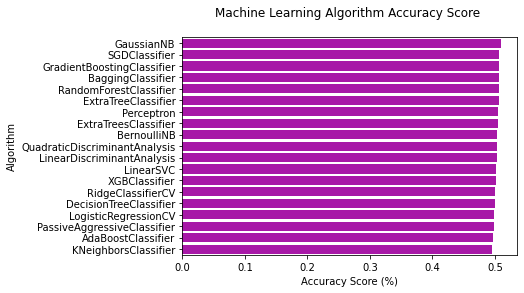

In [145]:
sns.barplot(x='MLA Test Accuracy Mean', y = 'MLA Name', data = MLA_compare, color = 'm')

#prettify using pyplot: https://matplotlib.org/api/pyplot_api.html
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')